In [13]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Colab_Notebooks/project_data/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab_Notebooks/project_data/project


In [2]:
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, LSTM, GRU, RNN, BatchNormalization, MaxPooling2D, Reshape
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [3]:
## Loading and visualizing the data

## Loading the dataset
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

## Adjusting the labels so that

# Cue onset left - 0
# Cue onset right - 1
# Cue onset foot - 2
# Cue onset tongue - 3

y_train_valid -= 769
y_test -= 769

(2115, 22, 1000)


In [4]:
def train_data_prep(X,y,sub_sample,average,noise):

    total_X = None
    total_y = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)

    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)

    # Averaging + noise
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)

    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging + noise and concatenating:',total_X.shape)

    # Subsampling
    for i in range(sub_sample):
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)

        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))

    print('Shape of X after subsampling and concatenating:', total_X.shape)
    print('Shape of Y:', total_y.shape)
    return total_X, total_y

def test_data_prep(X):
    total_X = None

    # Trimming the data (sample,22,1000) -> (sample,22,800)
    X = X[:,:,0:800]
    print('Shape of X after trimming:',X.shape)

    # Maxpooling the data (sample,22,800) -> (sample,22,800/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, 2), axis=3)

    total_X = X_max
    print('Shape of X after maxpooling:', total_X.shape)
    return total_X

In [5]:
## Preprocessing the dataset

# Define the model, loss function, and optimizer
x_train, x_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1)

x_train, y_train = train_data_prep(x_train, y_train, 2, 2, True)
x_valid, y_valid = train_data_prep(x_valid, y_valid, 2, 2, True)
X_test_prep = test_data_prep(X_test)
print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)

# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)
print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)

# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (1903, 22, 800)
Shape of X after maxpooling: (1903, 22, 400)
Shape of X after averaging + noise and concatenating: (3806, 22, 400)
Shape of X after subsampling and concatenating: (7612, 22, 400)
Shape of Y: (7612,)
Shape of X after trimming: (212, 22, 800)
Shape of X after maxpooling: (212, 22, 400)
Shape of X after averaging + noise and concatenating: (424, 22, 400)
Shape of X after subsampling and concatenating: (848, 22, 400)
Shape of Y: (848,)
Shape of X after trimming: (443, 22, 800)
Shape of X after maxpooling: (443, 22, 400)
Shape of training set: (7612, 22, 400)
Shape of validation set: (848, 22, 400)
Shape of training labels: (7612,)
Shape of validation labels: (848,)
Shape of training labels after categorical conversion: (7612, 4)
Shape of validation labels after categorical conversion: (848, 4)
Shape of test labels after categorical conversion: (443, 4)
Shape of training set after adding width info: (7612, 22, 400, 1)
Shape of validation set after 

In [35]:
# Building the CNN model using sequential class
def create_model(cnn_layers, filters, kernel_size, dropout, l2_lambda, gru_layers, gru_size):
    cnn_rnn_model = Sequential()

    cnn_rnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='elu', input_shape=(400,1,22), kernel_regularizer=l2(l2_lambda)))
    cnn_rnn_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
    cnn_rnn_model.add(BatchNormalization())
    cnn_rnn_model.add(Dropout(dropout))
    filters *= 2

    for i in range(cnn_layers - 1):
        cnn_rnn_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='elu', kernel_regularizer=l2(l2_lambda)))
        cnn_rnn_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
        cnn_rnn_model.add(BatchNormalization())
        cnn_rnn_model.add(Dropout(dropout))
        filters *= 2

    cnn_rnn_model.add(Flatten())
    cnn_rnn_model.add(Dense((gru_size * 2), kernel_regularizer=l2(l2_lambda)))
    cnn_rnn_model.add(Reshape((gru_size * 2, 1)))
    #cnn_rnn_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False, kernel_regularizer=l2(l2_lambda)))

    for i in range(gru_layers - 1):
        cnn_rnn_model.add(GRU(gru_size, dropout=0.4, return_sequences=True, kernel_regularizer=l2(l2_lambda)))
    cnn_rnn_model.add(GRU(gru_size, dropout=0.4, kernel_regularizer=l2(l2_lambda)))

    # Output layer with Softmax activation
    cnn_rnn_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    return cnn_rnn_model

In [38]:
# Compiling the model
cnn_layers = 3
gru_layers = 2
gru_size= 60
filters = 25
kernel_size = (7,1)
dropout = 0.5
l2_lambda = 0.001

# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_rnn_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
# Add early stopping callback to the list of callbacks
callbacks = [early_stopping]

cnn_rnn_model = create_model(cnn_layers, filters, kernel_size, dropout, l2_lambda, gru_layers, gru_size)

cnn_rnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_rnn_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_rnn_model_results = cnn_rnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid),
             callbacks=callbacks, verbose=True)

## Testing the hybrid CNN-RNN model
cnn_rnn_score = cnn_rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-RNN model:', cnn_rnn_score[1])

Epoch 1/100
119/119 [==============================] - 33s 29ms/step - loss: 1.5844 - accuracy: 0.3062 - val_loss: 1.4519 - val_accuracy: 0.3337
Epoch 2/100
119/119 [==============================] - 2s 18ms/step - loss: 1.4066 - accuracy: 0.4101 - val_loss: 1.3218 - val_accuracy: 0.4163
Epoch 3/100
119/119 [==============================] - 2s 15ms/step - loss: 1.3286 - accuracy: 0.4665 - val_loss: 1.2958 - val_accuracy: 0.4941
Epoch 4/100
119/119 [==============================] - 2s 15ms/step - loss: 1.2844 - accuracy: 0.4803 - val_loss: 1.2611 - val_accuracy: 0.4670
Epoch 5/100
119/119 [==============================] - 2s 15ms/step - loss: 1.2437 - accuracy: 0.5108 - val_loss: 1.3185 - val_accuracy: 0.4363
Epoch 6/100
119/119 [==============================] - 2s 15ms/step - loss: 1.2007 - accuracy: 0.5190 - val_loss: 1.3442 - val_accuracy: 0.4458
Epoch 7/100
119/119 [==============================] - 2s 16ms/step - loss: 1.1759 - accuracy: 0.5434 - val_loss: 1.2081 - val_accuracy

In [39]:
## Testing the hybrid CNN-RNN model
cnn_rnn_score = cnn_rnn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-RNN model:', cnn_rnn_score[1])

Test accuracy of the hybrid CNN-RNN model: 0.740406334400177


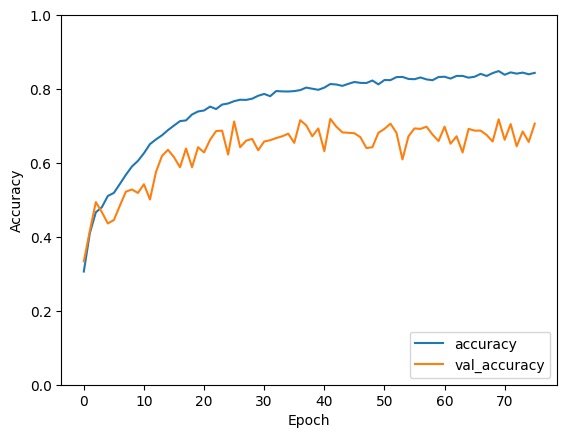

In [40]:

# Plotting
import matplotlib.pyplot as plt

plt.plot(cnn_rnn_model_results.history['accuracy'], label='accuracy')
plt.plot(cnn_rnn_model_results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()

# LSTM MODEL


In [41]:
from tensorflow.keras.layers import LSTM


In [42]:
# Building the CNN model using sequential class
def create_LSTM_model(cnn_layers, filters, kernel_size, dropout, l2_lambda, LSTM_layers, LSTM_size):
    cnn_LSTM_model = Sequential()

    cnn_LSTM_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='elu', input_shape=(400,1,22), kernel_regularizer=l2(l2_lambda)))
    cnn_LSTM_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
    cnn_LSTM_model.add(BatchNormalization())
    cnn_LSTM_model.add(Dropout(dropout))
    filters *= 2

    for i in range(cnn_layers - 1):
        cnn_LSTM_model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='elu', kernel_regularizer=l2(l2_lambda)))
        cnn_LSTM_model.add(MaxPooling2D(pool_size=(4,1), padding='same'))
        cnn_LSTM_model.add(BatchNormalization())
        cnn_LSTM_model.add(Dropout(dropout))
        filters *= 2

    cnn_LSTM_model.add(Flatten())
    cnn_LSTM_model.add(Dense((LSTM_size * 2), kernel_regularizer=l2(l2_lambda)))
    cnn_LSTM_model.add(Reshape((LSTM_size * 2, 1)))
    #cnn_LSTM_model.add(LSTM(10, dropout=0.4, recurrent_dropout=0.1, input_shape=(40,1), return_sequences=False, kernel_regularizer=l2(l2_lambda)))

    for i in range(LSTM_layers - 1):
        cnn_LSTM_model.add(LSTM(LSTM_size, dropout=0.4, return_sequences=True, kernel_regularizer=l2(l2_lambda)))
    cnn_LSTM_model.add(LSTM(LSTM_size, dropout=0.4, kernel_regularizer=l2(l2_lambda)))

    # Output layer with Softmax activation
    cnn_LSTM_model.add(Dense(4, activation='softmax')) # Output FC layer with softmax activation

    return cnn_LSTM_model

In [43]:
# Compiling the model
cnn_layers = 3
LSTM_layers = 2
LSTM_size= 60
filters = 25
kernel_size = (7,1)
dropout = 0.5
l2_lambda = 0.001

# Model parameters
learning_rate = 1e-3
epochs = 100
cnn_LSTM_optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=30, verbose=1, restore_best_weights=True)
# Add early stopping callback to the list of callbacks
callbacks = [early_stopping]

cnn_LSTM_model = create_model(cnn_layers, filters, kernel_size, dropout, l2_lambda, LSTM_layers, LSTM_size)

cnn_LSTM_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_LSTM_optimizer,
                 metrics=['accuracy'])




In [44]:
# Training and validating the model
cnn_LSTM_model_results = cnn_LSTM_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid),
             callbacks=callbacks, verbose=True)

Epoch 1/100
119/119 [==============================] - 9s 23ms/step - loss: 1.5562 - accuracy: 0.3443 - val_loss: 1.4115 - val_accuracy: 0.4186
Epoch 2/100
119/119 [==============================] - 2s 16ms/step - loss: 1.3808 - accuracy: 0.4276 - val_loss: 1.3069 - val_accuracy: 0.4222
Epoch 3/100
119/119 [==============================] - 2s 15ms/step - loss: 1.3248 - accuracy: 0.4682 - val_loss: 1.2969 - val_accuracy: 0.4151
Epoch 4/100
119/119 [==============================] - 2s 16ms/step - loss: 1.2890 - accuracy: 0.4837 - val_loss: 1.2855 - val_accuracy: 0.4351
Epoch 5/100
119/119 [==============================] - 2s 17ms/step - loss: 1.2454 - accuracy: 0.5067 - val_loss: 1.2676 - val_accuracy: 0.4446
Epoch 6/100
119/119 [==============================] - 3s 21ms/step - loss: 1.2026 - accuracy: 0.5340 - val_loss: 1.2399 - val_accuracy: 0.4741
Epoch 7/100
119/119 [==============================] - 2s 15ms/step - loss: 1.1806 - accuracy: 0.5437 - val_loss: 1.2276 - val_accuracy:

In [45]:
## Testing the hybrid CNN-LSTM model
cnn_LSTM_score = cnn_LSTM_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of the hybrid CNN-LSTM model:', cnn_LSTM_score[1])

Test accuracy of the hybrid CNN-LSTM model: 0.7291196584701538


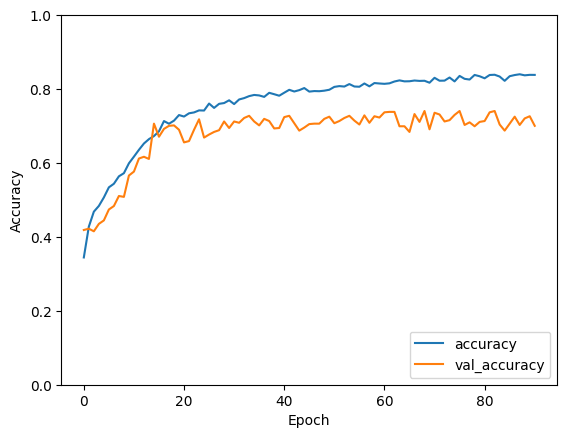

In [46]:

# Plotting
import matplotlib.pyplot as plt

plt.plot(cnn_LSTM_model_results.history['accuracy'], label='accuracy')
plt.plot(cnn_LSTM_model_results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.show()